<a href="https://colab.research.google.com/github/RA2112704010029/APPLIED-DEEP-LEARNING-/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code tells us the working of a Variational Autoencoder (VAE) using a "ship dataset"

In [ ]:
!pip install kagglehub

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - kl_loss: 18.6117 - loss: 0.0532 - reconstruction_loss: 0.0530 - val_loss: 0.0444
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - kl_loss: 3.0550 - loss: 0.0429 - reconstruction_loss: 0.0429 - val_loss: 0.0402
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - kl_loss: 3.0853 - loss: 0.0399 - reconstruction_loss: 0.0399 - val_loss: 0.0369
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - kl_loss: 4.0711 - loss: 0.0370 - reconstruction_loss: 0.0369 - val_loss: 0.0344
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - kl_loss: 5.4295 - loss: 0.0328 - reconstruction_loss: 0.0327 - val_loss: 0.0305
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - kl_loss: 6.0691 - loss: 0.0302 - reconstruction_loss: 0.0301 - val_loss: 0.0303
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - kl_loss: 6.6499 - loss: 0.0282 - reconstruction_loss: 0.0281 - val_loss: 0.0275
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - kl_loss: 7.0469 

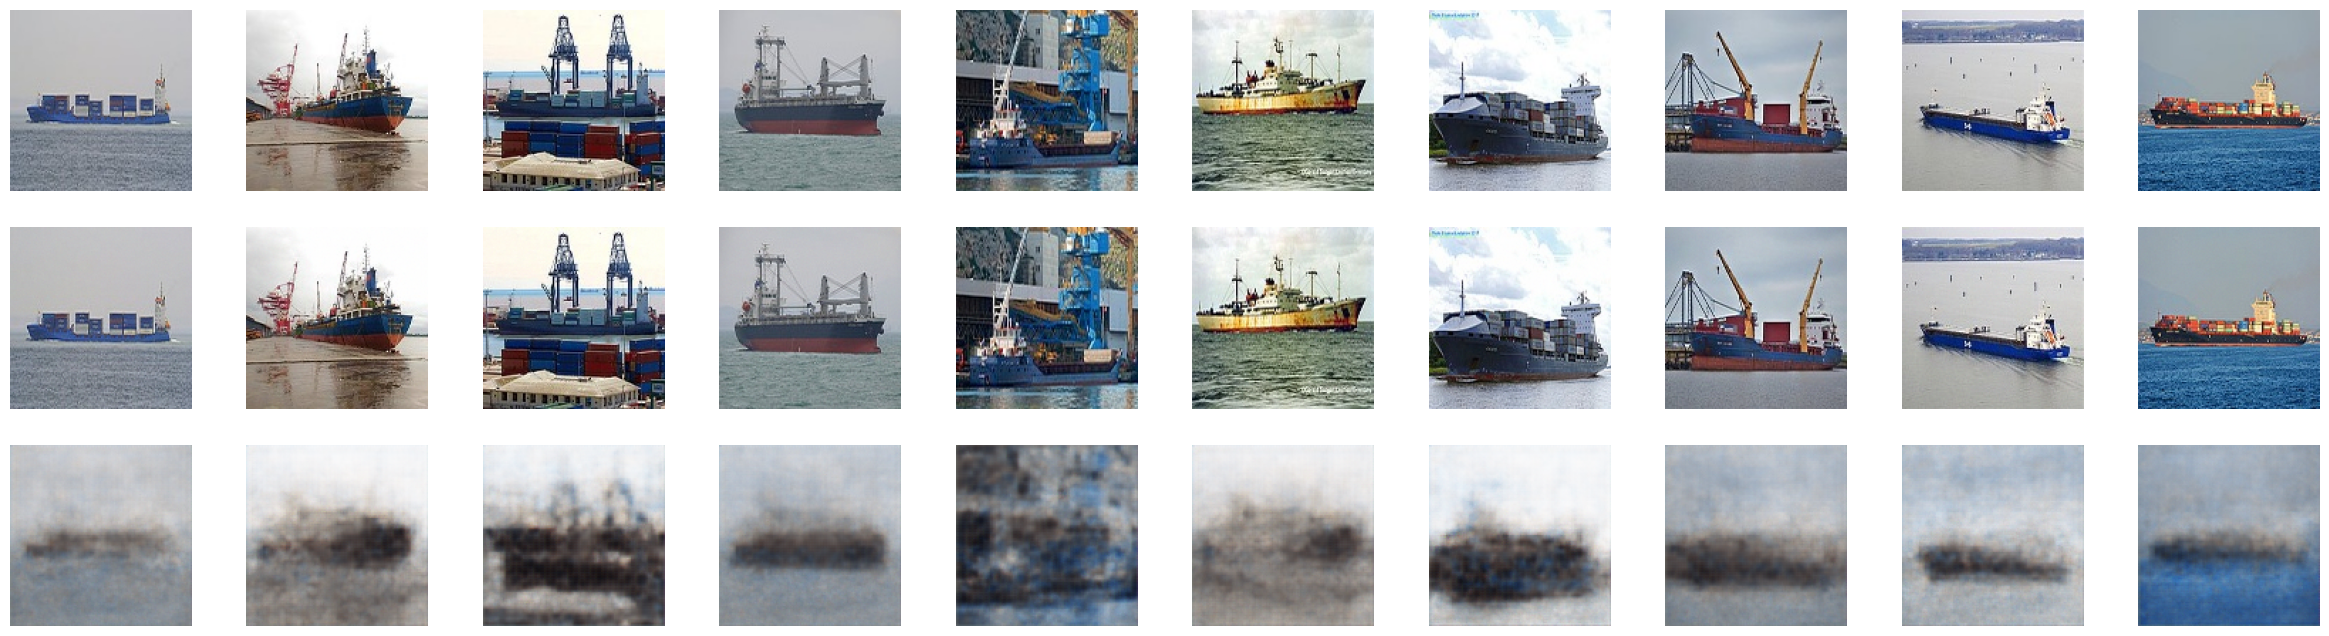

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.preprocessing import image
import glob

# Load and preprocess dataset
image_dir = '/root/.cache/kagglehub/datasets/canerbaloglu/ship-images-dataset/versions/1'
img_size = (128, 128)
valid_extensions = ('.jpg', '.jpeg', '.png')

# Get the first 500 image paths
image_paths = []
for root, _, files in os.walk(image_dir):
    for file in files:
        if file.lower().endswith(valid_extensions):
            image_paths.append(os.path.join(root, file))
image_paths = image_paths[:500]  # Use only 500 images

clean_images = []
for img_path in image_paths:
    img = image.load_img(img_path, target_size=img_size, color_mode='rgb')
    img_array = image.img_to_array(img) / 255.0
    clean_images.append(img_array)

clean_images = np.array(clean_images)

# Add minimal noise
noise_factor = 0.005
x_noisy = clean_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=clean_images.shape)
x_noisy = np.clip(x_noisy, 0.0, 1.0)

# Reshape data
x_train_noisy = x_noisy.reshape(-1, 128, 128, 3)
x_train_clean = clean_images.reshape(-1, 128, 128, 3)

# VAE parameters
latent_dim = 32
input_shape = (128, 128, 3)

# Sampling layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder
encoder_inputs = Input(shape=input_shape)
x = layers.Conv2D(16, 3, padding='same', activation='relu')(encoder_inputs)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

# Decoder
latent_inputs = Input(shape=(latent_dim,))
x = layers.Dense(32 * 32 * 32, activation='relu')(latent_inputs)
x = layers.Reshape((32, 32, 32))(x)
x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(16, 3, strides=2, padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(3, 3, padding='same', activation='sigmoid')(x)
decoder = Model(latent_inputs, x, name='decoder')

# VAE model
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.keras.losses.mse(y, reconstruction))
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + 0.00001 * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": total_loss, "reconstruction_loss": reconstruction_loss, "kl_loss": kl_loss}

vae = VAE(encoder, decoder)

# Compile with a dummy loss function
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Train model
history = vae.fit(x_train_noisy, x_train_clean, epochs=20, batch_size=8, validation_split=0.2)

# Generate denoised images
decoded_imgs = vae.predict(x_train_noisy)

# Visualize results
n = 10
plt.figure(figsize=(30, 8))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_train_clean[i])
    plt.axis('off')
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_train_noisy[i])
    plt.axis('off')
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i])
    plt.axis('off')
plt.show()

In [ ]:
#@title Convert ipynb to HTML in Colab
# Upload ipynb
from google.colab import files
f = files.upload()

# Convert ipynb to html
import subprocess
file0 = list(f.keys())[0]
_ = subprocess.run(["pip", "install", "nbconvert"])
_ = subprocess.run(["jupyter", "nbconvert", file0, "--to", "html"])

# download the html
files.download(file0[:-5]+"html")


Saving VAE_ShreyaVemana.ipynb to VAE_ShreyaVemana.ipynb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>